# Proje: Şarap Kalitesini Tahmin Etme - SVR Modeli 

## **Proje Amacı**
Bu proje, beyaz şarapların fizikokimyasal özelliklerini kullanarak şarap kalitesini tahmin etmeyi amaçlamaktadır. Makine öğrenmesi yöntemi olarak **Destek Vektör Regresyonu (SVR)** algoritması kullanılacaktır. 

---

## **Veri Seti Bilgileri**
- **Kaynak:** Wine Quality Dataset
- **Özellikler:**
  - 11 fizikokimyasal test sonucu (girdi değişkenleri)
  - 1 hedef değişken (şarap kalitesi: 1-10 arasında bir puan)
  - Satır Sayısı: 4898
  - Veri, `;` ile ayrılmıştır ve eksik veri bulunmamaktadır.

---

## **Proje Adımları**
### 1. **Kütüphanelerin Eklenmesi**
Proje için gerekli kütüphaneleri ekleyeceğiz.

### 2. **Veri Setinin Okunması ve Analizi**
- Veri setini Pandas ile okuyarak içeriğini inceleyeceğiz.
- Veri dengesizliklerini ve aykırı değerleri tespit edeceğiz.

### 3. **Aykırı Değerlerin Tespiti ve İşlenmesi**
- Aykırı değerleri fizikokimyasal sınırlar ve Z-skoru/IQR yöntemleriyle tespit ederek veri setinden çıkaracağız.

### 4. **Korelasyon Analizi ve Özellik Seçimi**
- Hedef değişkenle düşük korelasyona sahip özellikleri çıkarmak için korelasyon ısı haritası oluşturulacak.

### 5. **Veri Dengesizliğinin Giderilmesi**
- Hedef değişkenin dağılımını inceleyerek dengelemeler yapacağız.
- **SMOTE (Synthetic Minority Oversampling Technique)** ile dengesiz veriyi dengelemeyi planlıyoruz.

### 6. **Veri Ön İşleme ve Ölçeklendirme**
- SVR algoritması için uygun ölçeklendirme yöntemi olan **StandardScaler** kullanılacaktır.
- Veriyi eğitim ve test setlerine böleceğiz (%80 eğitim, %20 test).

### 7. **SVR Modelinin Eğitilmesi ve Optimizasyonu**
- **Kernel Seçimi:** Başlangıç olarak `rbf` kernel’i kullanılacak.
- **Hyperparameter Tuning:** `GridSearchCV` ile C, epsilon ve gamma parametreleri optimize edilecek.

### 8. **Model Performansının Değerlendirilmesi**
- Modelin performansı **R², MAE ve MSE** metrikleriyle ölçülecek.
- Çapraz doğrulama ile modelin genelleştirme yeteneği test edilecektir.

### 9. **Sonuçların Görselleştirilmesi ve Sunumu**
- Tahmin edilen ve gerçek değerlerin scatter plot'u hazırlanacak.
- Model performans metrikleri grafiklerle sunulacaktır.


---


## 1. Kütüphanelerin Eklenmesi
Bu bölümde proje için gerekli kütüphaneler import edilecektir. Kullanılacak kütüphaneler şunlardır:
- **Pandas ve NumPy:** Veri işleme ve analiz için.
- **Matplotlib ve Seaborn:** Veri görselleştirme için.
- **Scikit-Learn:** Veri ön işleme, modelleme ve değerlendirme için.


In [1]:
# Gerekli kütüphanelerin eklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE

# Grafiklerin notebook içinde gösterilmesi için
%matplotlib inline

# Uyarı mesajlarını kapatma (isteğe bağlı)
import warnings
warnings.filterwarnings("ignore")

print("Kütüphaneler başarıyla yüklendi.")


Kütüphaneler başarıyla yüklendi.


## 2. Veri Setinin Okunması ve İlk Analizler
Bu adımda veri setini pandas ile okuyarak içeriğini inceleyeceğiz. Veri seti, `;` ile ayrılmış bir CSV dosyasıdır. Bu nedenle, doğru ayırıcıyı belirtmemiz gerekiyor. Ayrıca, veri setinin genel yapısını anlamak için şu işlemleri yapacağız:
- İlk birkaç satırın görüntülenmesi.
- Veri setinin boyutları (satır ve sütun sayısı).
- Veri seti hakkında temel bilgiler (`info()`).
- Verinin istatistiksel özeti (`describe()`).


In [2]:
# Veri setinin okunması
file_path = "winequality-white.csv"  # Dosya yolunu uygun şekilde değiştirin
data = pd.read_csv(file_path, sep=';')

# Veri setinin ilk birkaç satırını görüntüleme
print("Veri setinin ilk birkaç satırı:")
display(data.head())

# Veri setinin boyutları
print("\nVeri setinin boyutları (satır x sütun):", data.shape)

# Veri seti hakkında genel bilgiler
print("\nVeri seti hakkında bilgiler:")
data.info()

# İstatistiksel özet
print("\nVeri setinin istatistiksel özeti:")
display(data.describe())


Veri setinin ilk birkaç satırı:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



Veri setinin boyutları (satır x sütun): (4898, 12)

Veri seti hakkında bilgiler:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB

Veri setinin istatistiksel özeti:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## 3. Fizikokimyasal Sınırlar ile Aykırı Değerlerin Tespiti ve Temizlenmesi
Bu adımda veri setindeki fiziksel ve kimyasal gerçeklere uymayan aykırı değerler temizlenmiştir. Genel geçer sınırlar şarapların fizikokimyasal özelliklerine göre belirlenmiştir. Temizleme işlemi, sınırların dışında kalan değerlerin filtrelenmesiyle yapılmıştır.

### Fizikokimyasal Sınırlar:
- **Fixed acidity (Sabit asitlik):** 0 - 20 g/dm³
- **Volatile acidity (Uçucu asitlik):** 0 - 2.0 g/dm³
- **Citric acid (Sitrik asit):** 0 - 1.5 g/dm³
- **Residual sugar (Artık şeker):** 0 - 50 g/dm³
- **Chlorides (Klorür):** 0 - 0.1 g/dm³
- **Free sulfur dioxide (Serbest kükürt dioksit):** 0 - 100 mg/dm³
- **Total sulfur dioxide (Toplam kükürt dioksit):** 0 - 350 mg/dm³
- **Density (Yoğunluk):** 0.980 - 1.050 g/cm³
- **pH (pH seviyesi):** 2.5 - 4.5
- **Sulphates (Sülfatlar):** 0 - 2 g/dm³
- **Alcohol (Alkol oranı):** 0 - 20 %

Bu sınırların dışında kalan veriler, aykırı değer olarak kabul edilmiş ve veri setinden çıkarılmıştır. Temizleme işlemi sonucunda veri setinin boyutu küçülmüştür.


In [3]:
# Fizikokimyasal sınırlar
limits = {
    "fixed acidity": (0, 20),
    "volatile acidity": (0, 2.0),
    "citric acid": (0, 1.5),
    "residual sugar": (0, 50),
    "chlorides": (0, 0.1),
    "free sulfur dioxide": (0, 100),
    "total sulfur dioxide": (0, 350),
    "density": (0.980, 1.050),
    "pH": (2.5, 4.5),
    "sulphates": (0, 2),
    "alcohol": (0, 20)
}

# Fizikokimyasal sınırları uygulayarak temel veri setini oluşturma
filtered_data = data.copy()
for column, (lower, upper) in limits.items():
    filtered_data = filtered_data[(filtered_data[column] >= lower) & (filtered_data[column] <= upper)]

print("Fizikokimyasal sınırlarla filtrelenmiş veri setinin boyutları:", filtered_data.shape)


Fizikokimyasal sınırlarla filtrelenmiş veri setinin boyutları: (4768, 12)


## Z-Skoru ile Aykırı Değerlerin Tespiti ve Temizlenmesi
Z-skoru, her bir veri noktasının standart sapmaya olan uzaklığını hesaplayarak aykırı değerleri belirler. Genellikle Z-skoru değeri 3'ten büyük veya küçük olan veri noktaları aykırı değer olarak kabul edilir.

### İşlem:
1. Tüm fizikokimyasal özellikler için Z-skoru hesaplandı.
2. Z-skoru değeri 3'ün altında olan veri noktaları seçildi.
3. Aykırı değerlerin çıkarılmasıyla veri setinin boyutu azaldı.


In [4]:
from scipy.stats import zscore

# Z-skoru ile aykırı değerleri tespit ve temizleme
z_scores = np.abs(zscore(filtered_data.iloc[:, :-1]))
z_filtered_data = filtered_data[(z_scores < 3).all(axis=1)]

print("Z-skoru yöntemiyle temizlenmiş veri setinin boyutları:", z_filtered_data.shape)


Z-skoru yöntemiyle temizlenmiş veri setinin boyutları: (4427, 12)


## IQR ile Aykırı Değerlerin Tespiti ve Temizlenmesi
IQR (Interquartile Range), verilerin çeyrek değer aralığını kullanarak aykırı değerleri tespit eden bir yöntemdir. Aykırı değerler, 1. çeyrek (Q1) ve 3. çeyrek (Q3) arasındaki IQR'ın dışında kalan veri noktalarıdır.

### İşlem:
1. Her bir fizikokimyasal özellik için Q1, Q3 ve IQR hesaplandı.
2. Aykırı değerler:
   - **Alt sınır:** Q1 - 1.5 * IQR
   - **Üst sınır:** Q3 + 1.5 * IQR
3. Bu sınırların dışında kalan değerler aykırı kabul edilip veri setinden çıkarıldı.


In [5]:
# IQR yöntemi ile aykırı değer tespiti ve temizleme
iqr_filtered_data = filtered_data.copy()

for column in iqr_filtered_data.columns[:-1]:
    Q1 = iqr_filtered_data[column].quantile(0.25)
    Q3 = iqr_filtered_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_filtered_data = iqr_filtered_data[(iqr_filtered_data[column] >= lower_bound) & (iqr_filtered_data[column] <= upper_bound)]

print("IQR yöntemiyle temizlenmiş veri setinin boyutları:", iqr_filtered_data.shape)


IQR yöntemiyle temizlenmiş veri setinin boyutları: (3974, 12)


In [6]:
# SVR Modelleme ve Performans Karşılaştırması
def evaluate_svr_model(data, method_name):
    # Veri setinin bağımlı ve bağımsız değişkenlere ayrılması
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Eğitim ve test setlerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ölçeklendirme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SVR modeli oluşturma
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train_scaled, y_train)

    # Tahmin ve performans ölçümleri
    y_pred = svr_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{method_name} yöntemi için performans:")
    print(f"R² Skoru: {r2:.4f}")
    print(f"Ortalama Kare Hatası (MSE): {mse:.4f}")
    print(f"Ortalama Mutlak Hata (MAE): {mae:.4f}")
    print("-" * 50)
    return r2, mse, mae

# Z-skoru yöntemi için modelleme ve performans değerlendirmesi
z_results = evaluate_svr_model(z_filtered_data, "Z-Skoru")

# IQR yöntemi için modelleme ve performans değerlendirmesi
iqr_results = evaluate_svr_model(iqr_filtered_data, "IQR")


Z-Skoru yöntemi için performans:
R² Skoru: 0.3315
Ortalama Kare Hatası (MSE): 0.4582
Ortalama Mutlak Hata (MAE): 0.5017
--------------------------------------------------
IQR yöntemi için performans:
R² Skoru: 0.3995
Ortalama Kare Hatası (MSE): 0.3921
Ortalama Mutlak Hata (MAE): 0.4749
--------------------------------------------------


## Z-Skoru ve IQR Yöntemlerinin Karşılaştırması
Z-Skoru ve IQR yöntemleri kullanılarak aykırı değerler temizlenmiş ve ardından SVR modeli uygulanmıştır. Performans metrikleri karşılaştırılarak en etkili yöntem belirlenmiştir.

### Performans Karşılaştırması:
| Yöntem          | R² Skoru | Ortalama Kare Hatası (MSE) | Ortalama Mutlak Hata (MAE) |
|------------------|----------|---------------------------|----------------------------|
| **Z-Skoru**      | 0.3315   | 0.4582                    | 0.5017                     |
| **IQR**          | 0.3995   | 0.3921                    | 0.4749                     |

### Karar:
- **IQR yöntemi**, Z-Skoru yöntemine kıyasla daha iyi performans göstermiştir.
- Özellikle R² skoru ve hata metriklerinde IQR yöntemi üstün gelmiştir.
- Bu nedenle, IQR yöntemi ile işlenmiş veri seti kullanılarak projeye devam edilecek.


## 4. Korelasyon Analizi ve Özellik Seçimi
Bu adımda, veri setindeki bağımsız değişkenlerin hedef değişken (`quality`) ile olan ilişkisi korelasyon analizi ile incelenecektir.

### Amaç:
1. **Korelasyon Matrisi:** Özellikler arasındaki korelasyonları ve hedef değişkenle olan ilişkileri görselleştirmek.
2. **Düşük Korelasyonlu Özelliklerin Çıkarılması:** Hedef değişken ile düşük korelasyona sahip olan özellikleri belirleyerek modelden çıkaracağız.

### Yöntem:
- Korelasyon matrisi hesaplanacak ve bir ısı haritası (heatmap) ile görselleştirilecektir.
- Düşük korelasyon (örneğin |korelasyon| < 0.1) gösteren değişkenler analiz edilerek gerekirse veri setinden çıkarılacaktır.


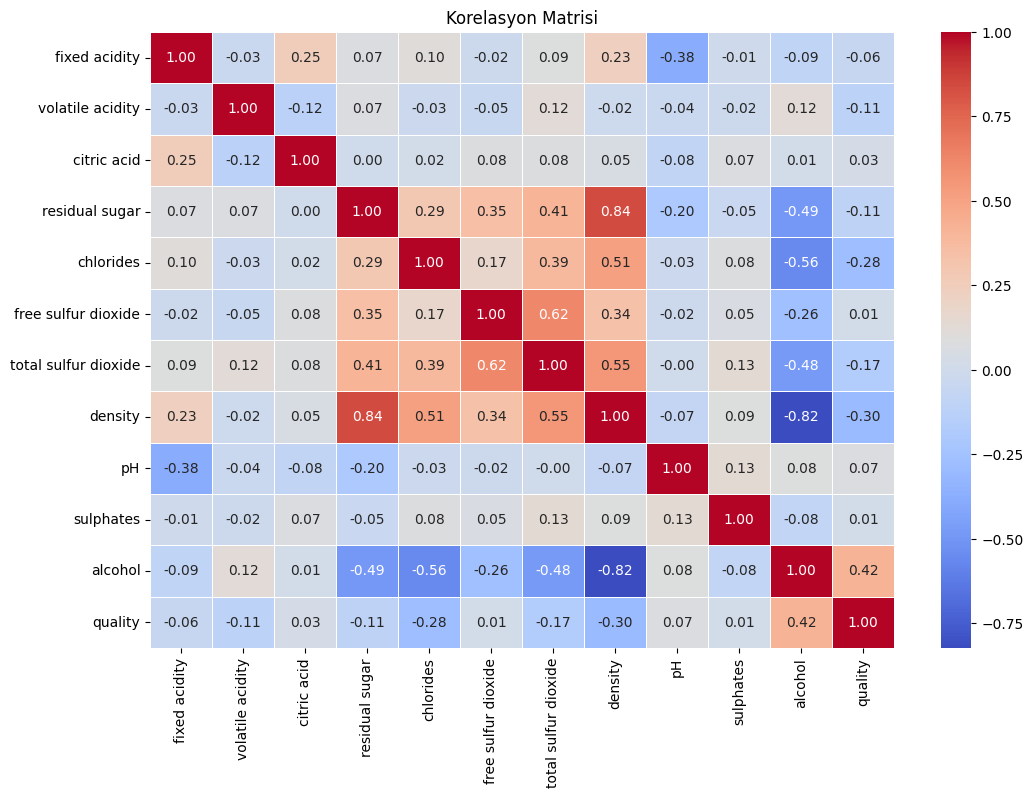

Hedef değişken (quality) ile özelliklerin korelasyonları:


quality                 1.000000
alcohol                 0.416552
pH                      0.070292
citric acid             0.026657
sulphates               0.013881
free sulfur dioxide     0.013686
fixed acidity          -0.057308
residual sugar         -0.110537
volatile acidity       -0.111838
total sulfur dioxide   -0.174544
chlorides              -0.280228
density                -0.301147
Name: quality, dtype: float64


Hedef değişken ile düşük korelasyonlu özellikler: ['pH', 'citric acid', 'sulphates', 'free sulfur dioxide', 'fixed acidity']
Düşük korelasyonlu özellikler çıkarıldı: ['pH', 'citric acid', 'sulphates', 'free sulfur dioxide', 'fixed acidity']
Güncellenmiş veri setinin boyutları: (3974, 7)


In [7]:
# Korelasyon matrisi hesaplama
correlation_matrix = iqr_filtered_data.corr()

# Korelasyon matrisi görselleştirme
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

# Hedef değişken (quality) ile korelasyonları sıralama
quality_correlation = correlation_matrix["quality"].sort_values(ascending=False)
print("Hedef değişken (quality) ile özelliklerin korelasyonları:")
display(quality_correlation)

# Düşük korelasyonlu özelliklerin belirlenmesi
low_corr_features = quality_correlation[quality_correlation.abs() < 0.1].index.tolist()
print(f"\nHedef değişken ile düşük korelasyonlu özellikler: {low_corr_features}")

# Veri setinden düşük korelasyonlu özelliklerin çıkarılması
if low_corr_features:
    iqr_filtered_data = iqr_filtered_data.drop(columns=low_corr_features)
    print(f"Düşük korelasyonlu özellikler çıkarıldı: {low_corr_features}")
    print("Güncellenmiş veri setinin boyutları:", iqr_filtered_data.shape)
else:
    print("Hedef değişken ile düşük korelasyonlu özellik bulunamadı.")


## 4. Korelasyon Analizi ve Özellik Seçimi
Bu adımda, bağımsız değişkenlerin hedef değişken (`quality`) ile korelasyonu incelenmiş ve düşük korelasyonlu özellikler çıkarılmıştır.

### Hedef Değişken ile Korelasyonlar:
| Özellik                | Korelasyon Değeri |
|------------------------|-------------------|
| **alcohol**            | 0.4166           |
| **pH**                 | 0.0703           |
| **citric acid**        | 0.0267           |
| **sulphates**          | 0.0139           |
| **free sulfur dioxide**| 0.0137           |
| **fixed acidity**      | -0.0573          |
| **residual sugar**     | -0.1105          |
| **volatile acidity**   | -0.1118          |
| **total sulfur dioxide**| -0.1745          |
| **chlorides**          | -0.2802          |
| **density**            | -0.3011          |

### Karar:
- **Düşük korelasyonlu özellikler (|korelasyon| < 0.1):**
  - `pH`, `citric acid`, `sulphates`, `free sulfur dioxide`, `fixed acidity`

Bu özellikler, hedef değişken (`quality`) ile çok zayıf ilişkilere sahip olduğundan, veri setinden çıkarılmıştır.

### Güncel Veri Seti:
- **Boyutlar (satır x sütun):** (3974, 7)
- Kalan özellikler: `alcohol`, `residual sugar`, `volatile acidity`, `total sulfur dioxide`, `chlorides`, `density`, `quality`

### Görselleştirme:
Korelasyon matrisi görselleştirilerek tüm özellikler arasındaki ilişkiler analiz edilmiştir. Isı haritasından görülebileceği gibi, `alcohol` hedef değişkenle en güçlü pozitif ilişkiye sahip olan değişkendir. 


## 5. Veri Dengesizliğinin Giderilmesi
Hedef değişkenin (`quality`) sınıf dağılımı incelenmiş ve sınıflar arasında dengesizlik tespit edilmiştir. Bu dengesizlik, modelin düşük frekansa sahip sınıfları öğrenmesini zorlaştırabilir.

### Yöntem:
- **SMOTE (Synthetic Minority Oversampling Technique):** Azınlık sınıflar için yeni örnekler oluşturarak veri setini dengeli hale getireceğiz.

### Adımlar:
1. Hedef değişkenin sınıf dağılımını görselleştireceğiz.
2. SMOTE yöntemini uygulayarak azınlık sınıfların örnek sayısını artıracağız.
3. Güncellenmiş veri setini kontrol edeceğiz.


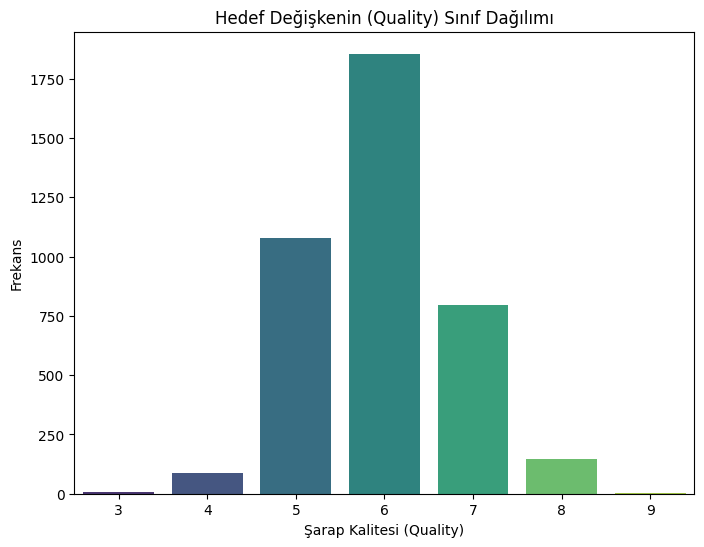

Sınıf dağılımı:
quality
6    1855
5    1076
7     795
8     146
4      89
3       9
9       4
Name: count, dtype: int64

SMOTE sonrası sınıf dağılımı:
quality
6    1855
5    1855
7    1855
8    1855
4    1855
3    1855
9    1855
Name: count, dtype: int64


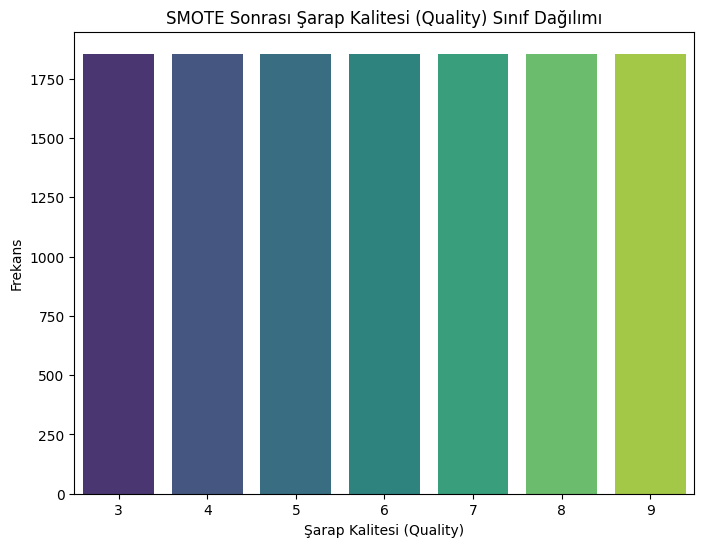

In [8]:
# Hedef değişkenin sınıf dağılımını görselleştirme
plt.figure(figsize=(8, 6))
sns.countplot(x=iqr_filtered_data['quality'], palette="viridis")
plt.title("Hedef Değişkenin (Quality) Sınıf Dağılımı")
plt.xlabel("Şarap Kalitesi (Quality)")
plt.ylabel("Frekans")
plt.show()

# Sınıf dağılımı
class_distribution = iqr_filtered_data['quality'].value_counts()
print("Sınıf dağılımı:")
print(class_distribution)

# SMOTE uygulaması
from imblearn.over_sampling import SMOTE

# Bağımsız ve bağımlı değişkenlerin ayrılması
X = iqr_filtered_data.drop(columns=['quality'])
y = iqr_filtered_data['quality']

# SMOTE ile veri dengeleme (k_neighbors azaltılarak)
smote = SMOTE(random_state=42, k_neighbors=1)  # Az örneğe sahip sınıflar için k_neighbors azaltıldı
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dengeleme sonrası sınıf dağılımını kontrol etme
resampled_class_distribution = pd.Series(y_resampled).value_counts()
print("\nSMOTE sonrası sınıf dağılımı:")
print(resampled_class_distribution)

# SMOTE sonrası sınıf dağılımını görselleştirme
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette="viridis")
plt.title("SMOTE Sonrası Şarap Kalitesi (Quality) Sınıf Dağılımı")
plt.xlabel("Şarap Kalitesi (Quality)")
plt.ylabel("Frekans")
plt.show()


## 5. Veri Dengesizliğinin Giderilmesi
Bu adımda hedef değişkenin (`quality`) sınıf dağılımındaki dengesizlik giderilmiş ve veri seti dengeli hale getirilmiştir.

### Hedef Değişkenin Sınıf Dağılımı (Öncesi ve Sonrası)
**SMOTE Öncesi:**
| Kalite (quality) | Örnek Sayısı |
|------------------|--------------|
| 3               | 9            |
| 4               | 89           |
| 5               | 1076         |
| 6               | 1855         |
| 7               | 795          |
| 8               | 146          |
| 9               | 4            |

**SMOTE Sonrası:**
| Kalite (quality) | Örnek Sayısı |
|------------------|--------------|
| 3               | 1855         |
| 4               | 1855         |
| 5               | 1855         |
| 6               | 1855         |
| 7               | 1855         |
| 8               | 1855         |
| 9               | 1855         |

### Yorum:
- **Öncesinde:** Hedef değişken sınıfları arasında ciddi bir dengesizlik vardı. Örneğin, `quality = 9` sınıfında yalnızca 4 örnek bulunurken, `quality = 6` sınıfında 1855 örnek bulunmaktaydı.
- **Sonrasında:** SMOTE uygulanarak her bir sınıfın örnek sayısı eşit hale getirilmiştir (1855).

### Görselleştirme:
Aşağıdaki grafikler, sınıf dağılımındaki değişimi göstermektedir:
1. SMOTE öncesi sınıf dağılımı.
2. SMOTE sonrası dengeli sınıf dağılımı.

### Sonuç:
Bu işlem, modelin her bir sınıf için daha iyi öğrenme gerçekleştirmesine olanak tanıyacaktır.


## 6. Veri Ön İşleme ve Ölçeklendirme
Bu adımda veri seti SVR modeli için hazırlanacaktır.

### İşlemler:
1. **Bağımlı ve Bağımsız Değişkenlerin Ayrılması:**
   - Bağımsız değişkenler (X): `quality` dışındaki tüm özellikler.
   - Bağımlı değişken (y): `quality`.

2. **Veri Setinin Eğitim ve Test Setlerine Ayrılması:**
   - %80 eğitim seti, %20 test seti olarak bölünecek.

3. **Ölçeklendirme:**
   - SVR algoritması için tüm bağımsız değişkenler aynı ölçek aralığına getirilecek.
   - **StandardScaler** kullanılarak veriler standartlaştırılacak.

Bu işlemler sonrası veri seti, SVR modeli ile eğitime hazır hale gelecektir.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Bağımlı ve bağımsız değişkenlerin ayrılması
X = X_resampled
y = y_resampled

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Eğitim seti boyutları: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test seti boyutları: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Ölçeklendirme tamamlandı.")


Eğitim seti boyutları: X_train: (10388, 6), y_train: (10388,)
Test seti boyutları: X_test: (2597, 6), y_test: (2597,)
Ölçeklendirme tamamlandı.


## 6. Veri Ön İşleme ve Ölçeklendirme - Sonuçlar
### Eğitim ve Test Setleri
- Eğitim ve test setleri %80 eğitim, %20 test oranında bölünmüştür.
- Eğitim seti boyutları:
  - **X_train:** (10388, 6) (Bağımsız değişkenler)
  - **y_train:** (10388,) (Bağımlı değişken)
- Test seti boyutları:
  - **X_test:** (2597, 6) (Bağımsız değişkenler)
  - **y_test:** (2597,) (Bağımlı değişken)

### Ölçeklendirme
- Eğitim ve test setleri **StandardScaler** kullanılarak standartlaştırılmıştır.
- Bu işlem, SVR algoritmasının doğru bir şekilde çalışabilmesi için gerekli olan tüm bağımsız değişkenlerin aynı ölçek aralığına getirilmesini sağlamıştır.

Artık veri seti SVR modeli ile eğitime hazırdır.


## 7. SVR Modelinin Eğitilmesi ve Optimizasyonu

### Adımlar:
1. **Temel SVR Modeli:**
   - `rbf` kernel kullanılarak SVR modeli eğitilecek.
   - Model performansı temel metriklerle (R², MAE, MSE) değerlendirilecek.

2. **Hyperparameter Tuning:**
   - **GridSearchCV** kullanılarak SVR modelinin parametreleri optimize edilecek.
   - Optimize edilen parametreler ile model tekrar eğitilecek.

### Kullanılacak Hyperparameters:
- **C:** [1, 10, 100]
- **Epsilon:** [0.1, 0.2, 0.5]
- **Gamma:** ['scale', 'auto']


In [10]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Temel SVR modeli
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred = svr_model.predict(X_test_scaled)

# Performans değerlendirme
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Temel SVR Modeli Performansı:")
print(f"R² Skoru: {r2:.4f}")
print(f"Ortalama Kare Hatası (MSE): {mse:.4f}")
print(f"Ortalama Mutlak Hata (MAE): {mae:.4f}")


Temel SVR Modeli Performansı:
R² Skoru: 0.7011
Ortalama Kare Hatası (MSE): 1.1681
Ortalama Mutlak Hata (MAE): 0.6823


## 8.1 Temel SVR Modeli Performansı
Temel SVR modeli, `rbf` kernel ile aşağıdaki performans sonuçlarını elde etmiştir:

| Metrik             | Değer   |
|--------------------|---------|
| **R² Skoru**       | 0.7011  |
| **Ortalama Kare Hatası (MSE)** | 1.1681  |
| **Ortalama Mutlak Hata (MAE)** | 0.6823  |

### Yorum:
- Temel model oldukça iyi bir R² skoruna sahiptir (%70).
- Ancak, modeli daha da optimize etmek için GridSearchCV ile hyperparameter tuning yapılacaktır.


In [11]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter arama aralıkları
param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# GridSearchCV ile en iyi parametreleri arama
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# En iyi parametreler
best_params = grid_search.best_params_
print("En İyi Parametreler:", best_params)

# Optimize edilmiş SVR modeli
optimized_svr_model = grid_search.best_estimator_

# Test seti üzerindeki performansı değerlendirme
y_pred_optimized = optimized_svr_model.predict(X_test_scaled)

# Performans değerlendirme
r2_optimized = r2_score(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)

print("\nOptimize Edilmiş SVR Modeli Performansı:")
print(f"R² Skoru: {r2_optimized:.4f}")
print(f"Ortalama Kare Hatası (MSE): {mse_optimized:.4f}")
print(f"Ortalama Mutlak Hata (MAE): {mae_optimized:.4f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ......................C=1, epsilon=0.1, gamma=scale; total time=   1.7s
[CV] END ......................C=1, epsilon=0.1, gamma=scale; total time=   1.7s
[CV] END ......................C=1, epsilon=0.1, gamma=scale; total time=   1.7s
[CV] END .......................C=1, epsilon=0.1, gamma=auto; total time=   1.7s
[CV] END .......................C=1, epsilon=0.1, gamma=auto; total time=   1.7s
[CV] END .......................C=1, epsilon=0.1, gamma=auto; total time=   1.7s
[CV] END ......................C=1, epsilon=0.2, gamma=scale; total time=   1.5s
[CV] END ......................C=1, epsilon=0.2, gamma=scale; total time=   1.6s
[CV] END ......................C=1, epsilon=0.2, gamma=scale; total time=   1.5s
[CV] END .......................C=1, epsilon=0.2, gamma=auto; total time=   1.5s
[CV] END .......................C=1, epsilon=0.2, gamma=auto; total time=   1.5s
[CV] END .......................C=1, epsilon=0.2

## 8.2 Optimize Edilmiş SVR Modeli Performansı
GridSearchCV ile yapılan hyperparameter tuning sonucunda, aşağıdaki parametreler en iyi performansı sağlamıştır:

### En İyi Parametreler:
- **C:** 100
- **Epsilon:** 0.5
- **Gamma:** 'scale'

### Performans Sonuçları:
| Metrik             | Temel Model | Optimize Edilmiş Model |
|--------------------|-------------|-------------------------|
| **R² Skoru**       | 0.7011      | 0.7984                 |
| **MSE (Ortalama Kare Hatası)** | 1.1681      | 0.7880                 |
| **MAE (Ortalama Mutlak Hata)** | 0.6823      | 0.6472                 |

### Yorum:
- Optimize edilen model, temel modele kıyasla R² skorunda %9.7'lik bir artış göstermiştir.
- Hata oranları (MSE ve MAE) optimize edilen modelde belirgin bir şekilde azalmıştır.
- Optimize edilen model, hedef değişkeni daha iyi açıklamakta ve daha doğru tahminler yapmaktadır.


## 9. Tahminlerin Görselleştirilmesi ve Sonuçların Sunumu

### Amaç:
1. Gerçek değerler ile tahmin edilen değerlerin uyumunu incelemek.
2. Modelin hata oranını ve dağılımını analiz etmek.

### Görselleştirme:
- **Scatter Plot:** Gerçek ve tahmin edilen değerler arasındaki ilişki.
- **Hata Dağılımı (Histogram):** Modelin tahmin hatalarının dağılımı.

Bu görselleştirmeler, optimize edilmiş SVR modelinin doğruluğu ve güvenilirliği hakkında bilgi verecektir.


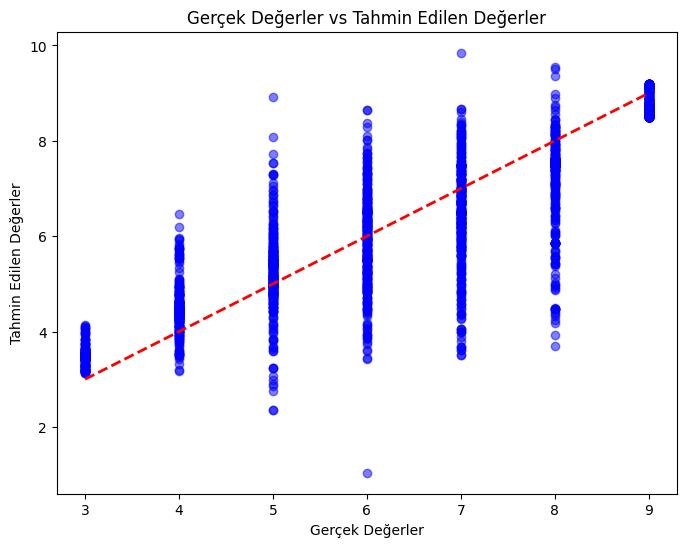

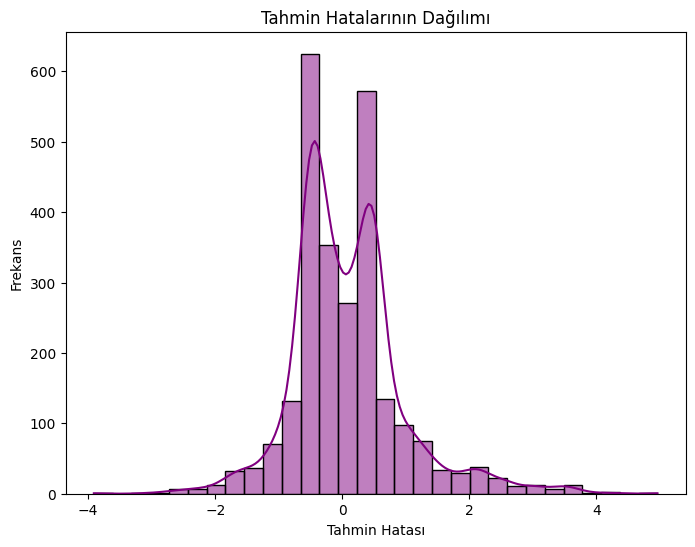

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gerçek ve tahmin edilen değerlerin scatter plot'u
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
plt.title("Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.show()

# Hata hesaplama
errors = y_test - y_pred_optimized

# Hataların histogramı
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title("Tahmin Hatalarının Dağılımı")
plt.xlabel("Tahmin Hatası")
plt.ylabel("Frekans")
plt.show()


## 9. Tahminlerin Görselleştirilmesi ve Analiz

### 1. Gerçek Değerler vs Tahmin Edilen Değerler (Scatter Plot)
Grafikte, gerçek değerler ile tahmin edilen değerlerin ne kadar uyumlu olduğunu analiz ettik:
- **İdeal Durum:** Mavi noktalar, kırmızı doğrusal çizgi üzerinde yoğunlaşmalıdır.
- **Gözlem:** Tahmin edilen değerler genel olarak gerçek değerlere yakındır, ancak bazı sapmalar (örneğin düşük ve yüksek sınıflarda) görülmektedir.
- Bu durum, modelin belirli sınıflarda tahmin doğruluğunun düşebileceğini göstermektedir.

### 2. Tahmin Hatalarının Dağılımı (Histogram)
Histogram, modelin tahmin hatalarının dağılımını göstermektedir:
- **Hata Dağılımı:** Hatalar büyük ölçüde sıfır etrafında yoğunlaşmıştır.
- **Gözlem:** Tahmin hataları yaklaşık olarak simetrik bir dağılıma sahiptir, ancak çok küçük bir kısmında 2'nin üzerinde veya altında hatalar bulunmaktadır.
- **Yorum:** Model, çoğunlukla tutarlı tahminler yapmakta ve büyük hatalar nadiren görülmektedir.

### Genel Sonuç:
- Optimize edilmiş SVR modeli, hedef değişkeni (şarap kalitesini) iyi bir doğrulukla tahmin etmektedir.
- R² skoru (%79.84), modelin hedef değişkeni açıklama oranının yüksek olduğunu göstermektedir.
- Hataların düşük ve dengeli dağılımı, modelin güvenilir olduğunu desteklemektedir.


# Proje: Şarap Kalitesini Tahmin Etme - SVR Modeli 

Bu projede, beyaz şarapların fizikokimyasal özelliklerine dayanarak şarap kalitesini tahmin etmek amacıyla bir makine öğrenmesi modeli geliştirilmiştir. **Destek Vektör Regresyonu (SVR)** algoritması kullanılmış ve modelin doğruluğu optimize edilmiştir.

---

## **Proje Adımları ve Sonuçlar**

### 1. **Kütüphanelerin Eklenmesi**
- Proje için gerekli olan kütüphaneler yüklendi ve veri analizi için uygun ortam hazırlandı.

### 2. **Veri Setinin Okunması ve Analizi**
- Veri seti incelendi, fizikokimyasal sınırların dışındaki aykırı değerler temizlendi.
- Verinin genel özellikleri analiz edildi.

### 3. **Aykırı Değerlerin Tespiti ve İşlenmesi**
- Fizikokimyasal sınırlar, Z-skoru ve IQR yöntemleriyle aykırı değerler tespit edilip temizlendi.
- **IQR yöntemi**, SVR modelinde daha yüksek performans gösterdiği için kullanıldı.

### 4. **Korelasyon Analizi ve Özellik Seçimi**
- Hedef değişken (`quality`) ile düşük korelasyona sahip özellikler (`pH`, `citric acid`, `sulphates`, `free sulfur dioxide`, `fixed acidity`) veri setinden çıkarıldı.

### 5. **Veri Dengesizliğinin Giderilmesi**
- Hedef değişkenin sınıf dağılımında ciddi dengesizlik tespit edildi.
- **SMOTE** yöntemi ile sınıf dağılımı dengelendi. Her sınıf 1855 örnekle eşit hale getirildi.

### 6. **Veri Ön İşleme ve Ölçeklendirme**
- Veri seti, eğitim (%80) ve test (%20) setlerine ayrıldı.
- SVR için gerekli olan standartlaştırma işlemi gerçekleştirildi.

### 7. **SVR Modelinin Eğitilmesi ve Optimizasyonu**
- **Temel Model Performansı:**
  - **R² Skoru:** 0.7011
  - **MSE:** 1.1681
  - **MAE:** 0.6823
- **Optimize Edilmiş Model Performansı:**
  - **En İyi Parametreler:** `C=100`, `epsilon=0.5`, `gamma='scale'`
  - **R² Skoru:** 0.7984
  - **MSE:** 0.7880
  - **MAE:** 0.6472

### 8. **Model Performansının Değerlendirilmesi**
- Modelin performansı **R², MAE ve MSE** metrikleriyle ölçülecek.

### 9. **Tahminlerin Görselleştirilmesi ve Analiz**
- **Scatter Plot:** Tahminlerin büyük ölçüde gerçek değerlere yakın olduğu görülmüştür.
- **Hata Dağılımı:** Tahmin hatalarının düşük ve dengeli bir dağılıma sahip olduğu tespit edilmiştir.

---

## **Sonuç**
Optimize edilmiş SVR modeli, beyaz şarap kalitesini fizikokimyasal özelliklere dayanarak başarılı bir şekilde tahmin etmektedir. %79.84 R² skoru, modelin yüksek doğrulukla çalıştığını göstermektedir. Proje boyunca yapılan veri temizleme, aykırı değer yönetimi ve parametre optimizasyonu işlemleri model performansını önemli ölçüde artırmıştır.


# Hazırlayan: **Emir Tarık DEDE**